In [1]:
%matplotlib inline
import sympy as sym
from scipy.optimize import curve_fit
from helper_script_stats_with_rha import *
from scipy.optimize import curve_fit


**Loading Data**

In [2]:
rhadaily = pd.read_csv('https://raw.githubusercontent.com/ahurford/covid-nl/main/NL-Hub/RHA_DailyData_Original_Public.csv')
sel_cols = ['CreationDate', 'regional_health_authority', 'total_number_of_cases', 'new_cases','currently_hospitalized', 
            'current_in_icu', 'total_number_recovered','total_number_of_deaths', 'active_cases', 'total_people_tested']
rhadaily = rhadaily[sel_cols]
rhadaily['CreationDate'] = pd.to_datetime(rhadaily['CreationDate'],format='%Y-%m-%d',errors = 'ignore').dt.date
# filter data from Dec 15 2021 ie when omicron was first reported in NL 
startdate = pd.to_datetime("2021-12-13").date()
enddate = pd.to_datetime("2022-01-21").date()
rhadaily = rhadaily[rhadaily['CreationDate'].between(startdate, enddate , inclusive = True)]
rhadaily.rename(columns={'CreationDate':'date'}, inplace=True)
# reset index
rhadaily = rhadaily.reset_index(drop=True)
# change numeric data type formats to integer
rhadaily['date'] = pd.to_datetime(rhadaily['date'])
# convert values in regional_health_authority to lower case
rhadaily['regional_health_authority'] = rhadaily['regional_health_authority'].str.lower()
for col in rhadaily.columns:
    if rhadaily[col].dtype not in ['object', 'datetime64[ns]']:
        rhadaily[col] = rhadaily[col].astype(int)

In [3]:
# check for missing data and replace
d = rhadaily[rhadaily['regional_health_authority'].isna()].index.tolist()
rhadaily['regional_health_authority'].loc[d] = 'western_rha'
# create total test positivity rate column
rhadaily['year'] = rhadaily['date'].dt.year
rhadaily['month'] = rhadaily['date'].dt.month

**Split Data Into Regional Health Authorities**

In [4]:
eastern_rha_data = rhadaily[rhadaily['regional_health_authority'] == 'eastern_rha'].reset_index(drop=True)
western_rha_data = rhadaily[rhadaily['regional_health_authority'] == 'western_rha'].reset_index(drop=True)
central_rha_data = rhadaily[rhadaily['regional_health_authority'] == 'central_rha'].reset_index(drop=True)
labradorgrenfell_rha_data = rhadaily[rhadaily['regional_health_authority'] == 'labradorgrenfell_rha'].reset_index(drop=True);

 #### Analyzing The Trend of Testing Volume According to Regional Health Authorities in Newfoundland

In [5]:
# create daily records for each column
dataframe = [eastern_rha_data, central_rha_data, western_rha_data,labradorgrenfell_rha_data]
test_stats = {'health_authority' : [], 'tests_after_omicron' : [], 'cases_after_testing' : [], 'percentage_of_positive_tests': [],'testing_rate': []}
rha_pop = [317664, 91201, 76608 ,36069]
for i in range(len(dataframe)):
    df = dataframe[i]
    if i == 0:
        name = 'EHA'
        pop = rha_pop[i]
    elif i == 1:
        name = 'CHA'
        pop = rha_pop[i]
    elif i == 2:
        name = 'WHA' 
        pop = rha_pop[i]
    else:
        name = 'LG-HA'
        pop = rha_pop[i]
    df['daily_tests'] = df['total_people_tested'].diff()
    df['cum_tests'] = df['daily_tests'].cumsum()
    df['daily_cases'] = df['total_number_of_cases'].diff()
    df['cum_cases'] = df['daily_cases'].cumsum()
    df['daily_deaths'] = df['total_number_of_deaths'].diff()
    df['daily_recovery'] = df['total_number_recovered'].diff()
    df['daily_hospitalized'] = df['currently_hospitalized'].diff()
    
    # drop the first row after the taking the successive differences
    df.drop([0],inplace=True)
    df['daily_test_pos_rate'] = (df['new_cases'] / df['daily_tests']) * 100

    test_after_omicron = df['daily_tests'].sum().astype(int)
    cases_after_testing = df['daily_cases'].sum().astype(int)
    percentage_of_positive_tests = round((cases_after_testing / test_after_omicron) * 100,2)

    test_stats['health_authority'].append(name)
    test_stats['tests_after_omicron'].append(test_after_omicron)
    test_stats['cases_after_testing'].append(cases_after_testing)
    test_stats['percentage_of_positive_tests'].append(round(percentage_of_positive_tests,2))
    test_stats['testing_rate'].append(round((test_after_omicron/pop),2))

    print(f'Testing Statistics: {name}')
    print('+-+'*25)
    print(f'Total number of people tested after the dicovery of omicron is: {test_after_omicron}')
    print(f'Total number of positive cases after testing: {cases_after_testing}')
    print(f'The percentage of tests that came out positive: {percentage_of_positive_tests}%')
    print(f'Testing rate per population: {round((test_after_omicron/pop),2)}% ')
    print('---'*25)

DF = pd.DataFrame(test_stats)

Testing Statistics: EHA
+-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-+
Total number of people tested after the dicovery of omicron is: 72747
Total number of positive cases after testing: 8148
The percentage of tests that came out positive: 11.2%
Testing rate per population: 0.23% 
---------------------------------------------------------------------------
Testing Statistics: CHA
+-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-+
Total number of people tested after the dicovery of omicron is: 14767
Total number of positive cases after testing: 1463
The percentage of tests that came out positive: 9.91%
Testing rate per population: 0.16% 
---------------------------------------------------------------------------
Testing Statistics: WHA
+-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-+
Total number of people tested after the dicovery of omicron is: 15732
Total number of positive cases after testing: 1338
The p

In [6]:
DF = DF.groupby('health_authority')[['tests_after_omicron','cases_after_testing','percentage_of_positive_tests','testing_rate']].sum().sort_values(by='health_authority')
DF['percentage_of_positive_tests'] = DF['percentage_of_positive_tests'].apply(lambda data: round(data,2))
DF.style.background_gradient(cmap='flare')

,tests_after_omicron,cases_after_testing,percentage_of_positive_tests,testing_rate
health_authority,,,,
CHA,14767,1463,9.910000,0.160000
EHA,72747,8148,11.200000,0.230000
LG-HA,7575,1480,19.540000,0.210000
WHA,15732,1338,8.500000,0.210000


In [7]:
DF.reset_index(inplace=True)
def normalize_col(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))
DF['percentage_of_positive_tests'] = round(DF['percentage_of_positive_tests'],2)
fig = make_subplots(rows=1, cols=2, specs=[[{},{}]],vertical_spacing=0.15,
                    horizontal_spacing=0.055,
                    x_title='Date',
                    y_title="Normalized Count", 
                    subplot_titles=("Normalized Tests & Cases Count in Each RHA ",
                                                                     "Test Positivity & Testing Rate in Each RHA "))
fig.add_trace(go.Bar(x = DF['health_authority'], y = normalize_col(DF['tests_after_omicron']),
                            hoverinfo = 'y+x+name',name="tests_after_omicron",marker_color = 'brown'),row=1, col=1)
fig.add_trace(go.Bar(x = DF['health_authority'], y = normalize_col(DF['cases_after_testing']),
                            hoverinfo = 'y+x+name',name="cases_after_testing",marker_color = 'darkorange'), row=1, col=1),

fig.add_trace(go.Bar(x = DF['health_authority'], y = DF['percentage_of_positive_tests'],
                            hoverinfo = 'y+x+name',name="%+ve_tests",marker_color = 'teal'),row=1, col=2)
fig.add_trace(go.Bar(x = DF['health_authority'], y = DF['testing_rate'],
                            hoverinfo = 'y+x+name',name="testing_rate",marker_color = 'red'), row=1, col=2)

fig.update_layout(height=500,width = 1000, showlegend=True,template='ggplot2',barmode = 'group') 

### What is the trend of total testing according to regional health authorities in NL?

We visualize below to see the respective features of the data and how they compare using line graphs.


In [8]:
eastern_rha_data = eastern_rha_data.set_index('date')
central_rha_data = central_rha_data.set_index('date')
western_rha_data = western_rha_data.set_index('date')
labradorgrenfell_rha_data = labradorgrenfell_rha_data.set_index('date')

In [9]:
# visualizing how rha compare cumulatively
plot_totals_rha(eastern_rha_data, central_rha_data, western_rha_data, labradorgrenfell_rha_data)

In [10]:
# visualizing how each rha compare daily
plot_dailys_rha(eastern_rha_data, central_rha_data, western_rha_data, labradorgrenfell_rha_data)

**Test Positivity Rates Across RHA**

In [11]:
daily_test_positivity(eastern_rha_data, central_rha_data, western_rha_data, labradorgrenfell_rha_data)

In [12]:
compare_daily_test_positivity(eastern_rha_data, central_rha_data, western_rha_data, labradorgrenfell_rha_data)

**Visualization of Each RHA Daily Tests, Cases, Hospitalization, Recovery & ICU Counts**

In [13]:
daily_analysis_eha(eastern_rha_data)

In [14]:
daily_analysis_cha(central_rha_data)

In [15]:

daily_analysis_wha(western_rha_data)

In [16]:
daily_analysis_wha(labradorgrenfell_rha_data)

### Association between testing and cases.

Our statistics of concern to determine whether the models are viable for each RHA or not are:

* The coefficients and its p-value(significance)

* R-squared value

* F-statistic and its significance


In [17]:
import statsmodels.api as sm
# repeating the population of NL
eastern_rha_data['pop'] = 317664
central_rha_data['pop'] = 91201
western_rha_data['pop'] = 76608
labradorgrenfell_rha_data['pop'] = 36069

**EASTERN HEALTH REGION**


In [18]:
# selecting the total cases and population as independent variables
X = eastern_rha_data[['cum_cases','pop']]
    # selecting cumulative tests as dependent
y = eastern_rha_data['cum_tests']
# split before and after 3rd
train_X_til_3rd = X.loc['2021-12-15':'2022-01-03']
test_X_aft_3rd = X.loc['2022-01-04':]
# split before and after 3rd
train_y_til_3rd = y.loc['2021-12-15':'2022-01-03']
testy_aft_3rd = y.loc['2022-01-04':]

# modeling with the OLS method
train_X_til_3rd = sm.add_constant(train_X_til_3rd)
linear_regr_til_3rd = sm.OLS(train_y_til_3rd, train_X_til_3rd)
results_til_3rd = linear_regr_til_3rd.fit()

print('+-+'*20)
print(f'Mode Summary for Eastern Health Region')
print('+-+'*20)

print(results_til_3rd.summary())

+-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-+
Mode Summary for Eastern Health Region
+-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-+
                            OLS Regression Results                            
Dep. Variable:              cum_tests   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     115.1
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           8.33e-07
Time:                        23:07:27   Log-Likelihood:                -111.58
No. Observations:                  12   AIC:                             227.2
Df Residuals:                      10   BIC:                             228.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

- The coefficient for cumulative cases is 13.5875 and that of population is 0.0156, and their corresponding p-values are zero (0). That implies the coefficients are statistically significant.

- R-squared value is 0.92, which means that 92% of the testing variance can be explained by the number of cases and eastern health population using this line.

- Prob F-statistic has a very low p-value, practically zero, which implies that the model fit is statistically significant.

**Fitting Eastern Health RegionTesting Data Until 3rd January Using the Power Law**


Cofficients obtained:

- number of cases: 903.909

- population: 0.457

a = 903.9093202750272 , b = 0.4574236131238363


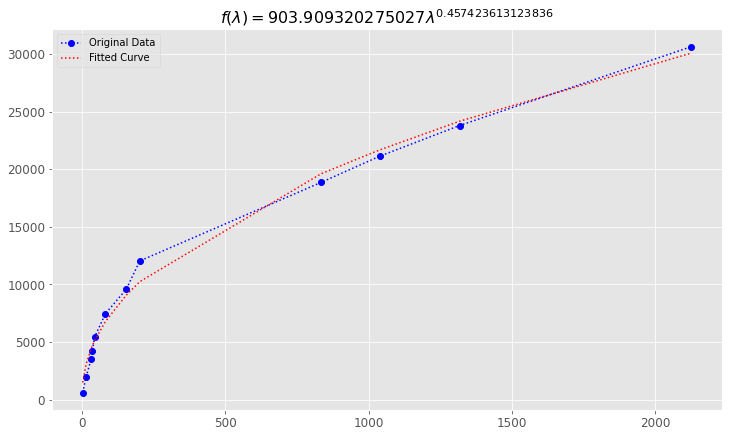

In [19]:
#transform your data in a numpy array of floats so the curve_fit can work
x = np.array(train_X_til_3rd['cum_cases'].values, dtype=float) 
y = np.array(train_y_til_3rd, dtype=float) 

# defined function that mimic the test data
def power_law(x, a, b):
    return a*np.power(x, b)

# make the curve_fit
popt, pcov = curve_fit(power_law, x, y)
# print parameters 
print("a = %s , b = %s" % (popt[0], popt[1])) #, popt[2], popt[3])
# use sympy to generate the latex sintax of the function
xs = sym.Symbol('\lambda')    
tex = sym.latex(power_law(xs,*popt)).replace('$', '')
# Print the coefficients and plot the funcion
plt.Figure(figsize=(12,7))
plt.plot(train_X_til_3rd['cum_cases'].values, train_y_til_3rd,label="Original Data", marker = 'o', c='b',ls = ':')
plt.plot(x, power_law(x, *popt), label="Fitted Curve", c='r', ls = ':') 
plt.title(r'$f(\lambda)= %s$' %(tex),fontsize=16)
plt.legend(loc='best')
plt.show()

**CENTRAL HEALTH REGION**

In [20]:
# selecting the total cases and population as independent variables
X = central_rha_data[['cum_cases','pop']]
    # selecting cumulative tests as dependent
y = central_rha_data['cum_tests']
# split before and after 3rd
train_X_til_3rd = X.loc['2021-12-15':'2022-01-03']
test_X_aft_3rd = X.loc['2022-01-04':]
# split before and after 3rd
train_y_til_3rd = y.loc['2021-12-15':'2022-01-03']
testy_aft_3rd = y.loc['2022-01-04':]

# modeling with the OLS method
train_X_til_3rd = sm.add_constant(train_X_til_3rd)
linear_regr_til_3rd = sm.OLS(train_y_til_3rd, train_X_til_3rd)
results_til_3rd = linear_regr_til_3rd.fit()

print('+-+'*20)
print(f'Mode Summary for Central Health Region')
print('+-+'*20)

print(results_til_3rd.summary())

+-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-+
Mode Summary for Central Health Region
+-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-+
                            OLS Regression Results                            
Dep. Variable:              cum_tests   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     50.52
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           3.27e-05
Time:                        23:07:28   Log-Likelihood:                -100.38
No. Observations:                  12   AIC:                             204.8
Df Residuals:                      10   BIC:                             205.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

- The coefficient for cumulative cases is 18.4949  and that of population is  0.0194, and their corresponding p-values are zero (0). That implies the coefficients are statistically significant.

- R-squared value is 0.835, which means that 83.5% of the testing variance can be explained by the number of cases and central health population using this line.

- Prob F-statistic has a very low p-value, practically zero, which implies that the model fit is statistically significant.

**Fitting Central Health Region Testing Data Until 3rd January Using the Power Law**


Cofficients obtained:

- number of cases: 430.459

- population: 0.499

a = 430.45856748196326 , b = 0.49862014884127154


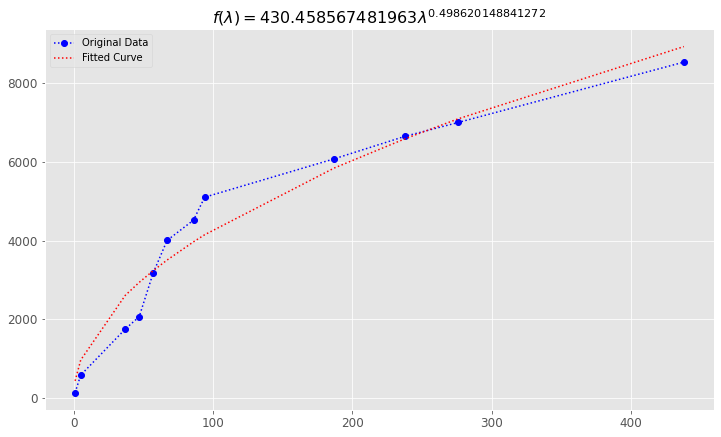

In [21]:
#transform your data in a numpy array of floats so the curve_fit can work
x = np.array(train_X_til_3rd['cum_cases'].values, dtype=float) 
y = np.array(train_y_til_3rd, dtype=float) 

# defined function that mimic the test data
def power_law(x, a, b):
    return a*np.power(x, b)

# make the curve_fit
popt, pcov = curve_fit(power_law, x, y)
# print parameters 
print("a = %s , b = %s" % (popt[0], popt[1])) #, popt[2], popt[3])
# use sympy to generate the latex sintax of the function
xs = sym.Symbol('\lambda')    
tex = sym.latex(power_law(xs,*popt)).replace('$', '')
# Print the coefficients and plot the funcion
plt.Figure(figsize=(12,7))
plt.plot(train_X_til_3rd['cum_cases'].values, train_y_til_3rd,label="Original Data", marker = 'o', c='b',ls = ':')
plt.plot(x, power_law(x, *popt), label="Fitted Curve", c='r', ls = ':') 
plt.title(r'$f(\lambda)= %s$' %(tex),fontsize=16)
plt.legend(loc='best')
plt.show()

**WESTERN HEALTH REGION**

In [22]:
# selecting the total cases and population as independent variables
X = western_rha_data[['cum_cases','pop']]
    # selecting cumulative tests as dependent
y = western_rha_data['cum_tests']
# split before and after 3rd
train_X_til_3rd = X.loc['2021-12-15':'2022-01-03']
test_X_aft_3rd = X.loc['2022-01-04':]
# split before and after 3rd
train_y_til_3rd = y.loc['2021-12-15':'2022-01-03']
testy_aft_3rd = y.loc['2022-01-04':]

# modeling with the OLS method
train_X_til_3rd = sm.add_constant(train_X_til_3rd)
linear_regr_til_3rd = sm.OLS(train_y_til_3rd, train_X_til_3rd)
results_til_3rd = linear_regr_til_3rd.fit()

print('+-+'*20)
print(f'Mode Summary for Western Health Region')
print('+-+'*20)

print(results_til_3rd.summary())

+-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-+
Mode Summary for Western Health Region
+-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-+
                            OLS Regression Results                            
Dep. Variable:              cum_tests   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     88.10
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           2.83e-06
Time:                        23:07:29   Log-Likelihood:                -96.611
No. Observations:                  12   AIC:                             197.2
Df Residuals:                      10   BIC:                             198.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

- The coefficient for cumulative cases is 20.4618  and that of population is  0.0205, and their corresponding p-values are zero (0). That implies the coefficients are statistically significant.

- R-squared value is 0.898, which means that 89.8% of the testing variance can be explained by the number of cases and western health population using this line.

- Prob F-statistic has a very low p-value, practically zero, which implies that the model fit is statistically significant.

**Fitting Western Health Region Testing Data Until 3rd January Using the Power Law**


Cofficients obtained:

- number of cases: 257.515

- population: 0.594

a = 257.5154604243376 , b = 0.5944648011387946


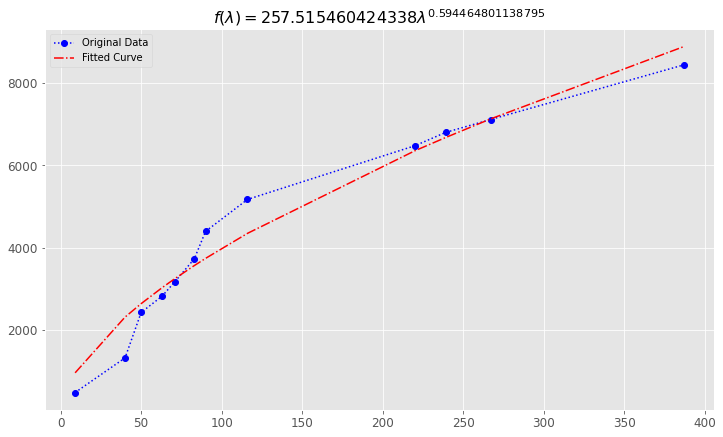

In [23]:
#transform your data in a numpy array of floats so the curve_fit can work
x = np.array(train_X_til_3rd['cum_cases'].values, dtype=float) 
y = np.array(train_y_til_3rd, dtype=float) 

# defined function that mimic the test data
def power_law(x, a, b):
    return a*np.power(x, b)

# make the curve_fit
popt, pcov = curve_fit(power_law, x, y)
# print parameters 
print("a = %s , b = %s" % (popt[0], popt[1])) #, popt[2], popt[3])
# use sympy to generate the latex sintax of the function
xs = sym.Symbol('\lambda')    
tex = sym.latex(power_law(xs,*popt)).replace('$', '')
# Print the coefficients and plot the funcion
plt.Figure(figsize=(12,7))
plt.plot(train_X_til_3rd['cum_cases'].values, train_y_til_3rd,label="Original Data", marker = 'o', c='b',ls = ':')
plt.plot(x, power_law(x, *popt), label="Fitted Curve", c='r',ls = '-.') 
plt.title(r'$f(\lambda)= %s$' %(tex),fontsize=16)
plt.legend(loc='best')
plt.show()

**LABRADOR-GRENFELL HEALTH REGION**

In [24]:
# selecting the total cases and population as independent variables
X = labradorgrenfell_rha_data[['cum_cases','pop']]
    # selecting cumulative tests as dependent
y = labradorgrenfell_rha_data['cum_tests']
# split before and after 3rd
train_X_til_3rd = X.loc['2021-12-15':'2022-01-03']
test_X_aft_3rd = X.loc['2022-01-04':]
# split before and after 3rd
train_y_til_3rd = y.loc['2021-12-15':'2022-01-03']
testy_aft_3rd = y.loc['2022-01-04':]

# modeling with the OLS method
train_X_til_3rd = sm.add_constant(train_X_til_3rd)
linear_regr_til_3rd = sm.OLS(train_y_til_3rd, train_X_til_3rd)
results_til_3rd = linear_regr_til_3rd.fit()

print('+-+'*20)
print(f'Mode Summary for Eastern Health Region')
print('+-+'*20)

print(results_til_3rd.summary())

+-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-+
Mode Summary for Eastern Health Region
+-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-++-+
                            OLS Regression Results                            
Dep. Variable:              cum_tests   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     227.1
Date:                Mon, 31 Jan 2022   Prob (F-statistic):           3.34e-08
Time:                        23:07:29   Log-Likelihood:                -78.398
No. Observations:                  12   AIC:                             160.8
Df Residuals:                      10   BIC:                             161.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

- The coefficient for cumulative cases is 5.5263   and that of population is  0.0105, and their corresponding p-values are zero (0). That implies the coefficients are statistically significant.

- R-squared value is 0.958, which means that 95.8% of the testing variance can be explained by the number of cases and labrador-grenfell health population using this line.

- Prob F-statistic has a very low p-value, practically zero, which implies that the model fit is statistically significant.

**Fitting Labrador-Grenfell Health Authority Testing Data Until 3rd January Using the Power Law**

Cofficients obtained:

- number of cases: 178.99

- population: 0.442

a = 178.9937541472815 , b = 0.44200864052951966


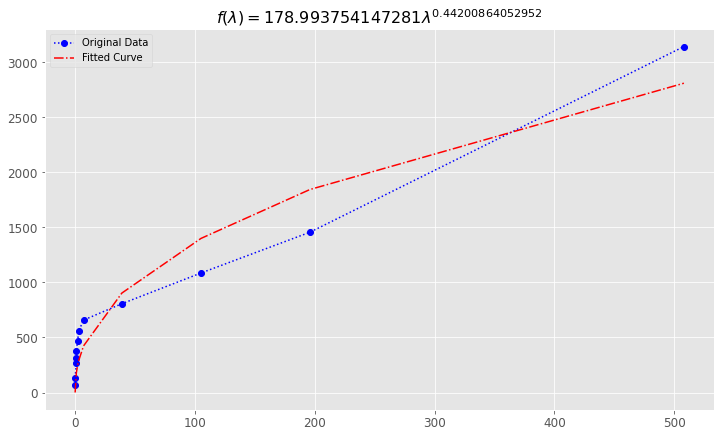

In [25]:
#transform your data in a numpy array of floats so the curve_fit can work
x = np.array(train_X_til_3rd['cum_cases'].values, dtype=float) 
y = np.array(train_y_til_3rd, dtype=float) 

# defined function that mimic the test data
def power_law(x, a, b):
    return a*np.power(x, b)

# make the curve_fit
popt, pcov = curve_fit(power_law, x, y)
# print parameters 
print("a = %s , b = %s" % (popt[0], popt[1])) #, popt[2], popt[3])
# use sympy to generate the latex sintax of the function
xs = sym.Symbol('\lambda')    
tex = sym.latex(power_law(xs,*popt)).replace('$', '')
# Print the coefficients and plot the funcion
plt.Figure(figsize=(12,7))
plt.plot(train_X_til_3rd['cum_cases'].values, train_y_til_3rd,label="Original Data", marker = 'o', c='b',ls = ':')
plt.plot(x, power_law(x, *popt), label="Fitted Curve", c='r',ls = '-.') 
plt.title(r'$f(\lambda)= %s$' %(tex),fontsize=16)
plt.legend(loc='best')
plt.show()